# Visualizing Convolutional Filters
While replicating webcam eye tracking model in Valliappan et al. (2020), I thought it would be interesting to get an understanding of what convolutional filters in the model are picking up on, so in this notebook I will visualize the first few convolutional filters.

In [1]:
# Import the packages
import tensorflow as tf
from models.base_model_2 import BaseModelBuilder
from experiments.experiment_runner import get_config
import matplotlib.pyplot as plt
from models.utils import get_base_model_datasets

I will get the the config file I used to train the original model and change the path to the datasets to make use of a smaller one for the purposes of demonstration. Then, I build the model using the config file and load in the best weights as well as the datasets.

In [2]:
# Get the config file to replicate model's hyper parameters
config = get_config('configs/exp_1.0.yml')

# Change data paths and batch size to get a sample from the data
config['train_data_path'] = 'data/valid.tfrecords'
config['val_data_path'] = 'data/valid.tfrecords'
config['batch_size'] = 1

# Build the model from config
model = BaseModelBuilder(config).build()

# Load model weights
model.load_weights('experiments/v1/v1.0/weights/modelv1.0.18-2.22.h5')

# Load TFRecord datasets
train, valid = get_base_model_datasets(config)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-07-17 11:37:32.677947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-17 11:37:32.677975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-17 11:37:33.094185: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Now I define a function for getting the filters from the model. It simply extracts the layers and wraps everything in <code>tf.keras.Model</code>. Then, it uses one image to make a prediction (aka apply the filters).

In [3]:
def get_filters(conv_name):
    """
    Extracts conv layers from the model and sends the data through
    the extracted layers to apply filters to the images.
    """

    # Extract conv layers and wrap them ib tf.keras.Model
    for layer in model.layers:
        if layer.name == 'Conv_Tower':
            for lay in layer.layers:

                # Define CONV1 layer as an input
                if lay.name == 'CONV1':
                    inp = lay.input

                # Define another layer as an output
                if lay.name == conv_name:
                    conv_sim = tf.keras.Model(inputs=inp, outputs=lay.output)

    # Take a random image from the dataset and get the left eye
    for i, ex in enumerate(valid.take(5000)):
        if i == 200:
            img = ex[0]['eye_left']

    # Send the image through the conv layers to apply fitlers
    feature_maps = conv_sim.predict(img)

    # Define figure parameters
    cols = 8
    rows = 4
    ix = 1

    # Plot the first 32 filters in greyscale
    for _ in range(32):
        ax = plt.subplot(rows, cols, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')

        ix += 1
    plt.show()

Call the function 3 time to get results for 3 layers and see the progression of the feature maps.

8/8 [==============================] - 0s 7ms/step


2023-07-17 11:38:00.220759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


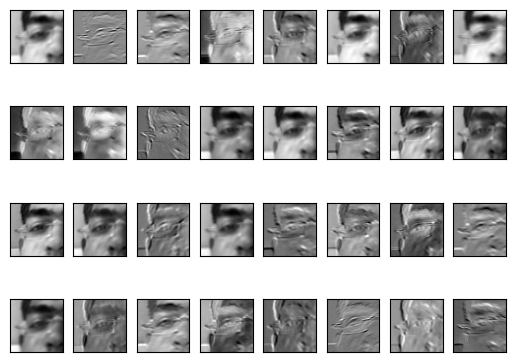

1/8 [==>...........................] - ETA: 0s

2023-07-17 11:38:19.270044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 25ms/step


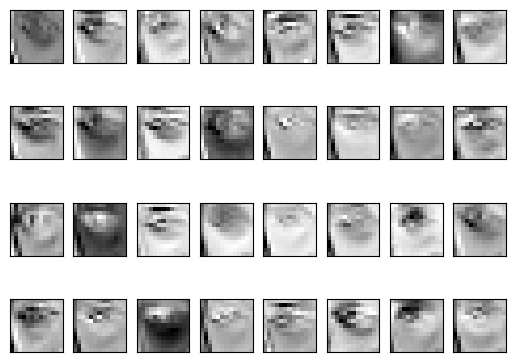

8/8 [==============================] - 0s 14ms/step


2023-07-17 11:38:38.235827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


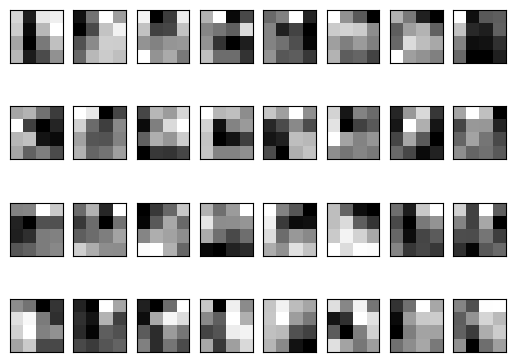

In [4]:
# Call the function 3 times to extract filters from conv1 to conv3
get_filters("CONV1")
get_filters("CONV2")
get_filters("CONV3")

CONV2 seems to be the most interesting set of feature maps. Looks like it's blowing up the eye features (some of them are kind of creepy) to make gaze location prediction. 